# Tile plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/23 03:05:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/23 03:05:17 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
data_path = "data/parquet_files/PlantCLEF2024_test"

# paths to dataframe
test_path = f"{gcs_path}/{data_path}"
# read data
test_df = spark.read.parquet(test_path)
# show
test_df.show(n=5, truncate=50)

+-------------------------------------------+------------------------+--------------------------------------------------+
|                                       path|              image_name|                                              data|
+-------------------------------------------+------------------------+--------------------------------------------------+
| /PlantCLEF2024test/CBN-Pla-B4-20160728.jpg| CBN-Pla-B4-20160728.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-D3-20130808.jpg| CBN-Pla-D3-20130808.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
|/PlantCLEF2024test/CBN-PdlC-E4-20150701.jpg|CBN-PdlC-E4-20150701.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-F5-20150901.jpg| CBN-Pla-F5-20150901.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-D1-20180724.jpg| CBN-Pla-D1-20180724.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
+-----------------------

In [4]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

In [5]:
# get subset of data
test_limit_df = test_df.limit(10).cache()

In [71]:
def split_into_grid(image_path, grid_size):
    image = Image.open(image_path)
    w, h = image.size
    grid_w, grid_h = w // grid_size, h // grid_size
    tiles = []
    for j in range(grid_size):  # Iterate over rows first
        for i in range(grid_size):  # Iterate over columns second
            left = i * grid_w
            upper = j * grid_h
            right = left + grid_w
            lower = upper + grid_h
            crop_image = image.crop((left, upper, right, lower))
            byte_arr = io.BytesIO()
            crop_image.save(byte_arr, format="PNG")
            tiles.append(byte_arr.getvalue())
    return tiles


def plot_images_grid_from_path(image_path, grid_size=(3, 3)):
    """
    Display the original image and a grid of patches.

    :param image_path: Path to the image file.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Split the image into tiles
    tiles = split_into_grid(image_path, grid_size[0])

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 10), dpi=120)

    for i, (ax, tile_data) in enumerate(zip(axes.flatten(), tiles)):
        tile_image = Image.open(io.BytesIO(tile_data))
        ax.imshow(tile_image)
        ax.set_xlabel(f"Tile {i+1}", fontsize=28)
        ax.set_xticks([])
        ax.set_yticks([])
        spines = ["top", "right", "bottom", "left"]
        for spine in spines:
            ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    path = Path(os.getcwd()).parents[1]
    plt.savefig(f"{path}/figures/image-tiles.png", bbox_inches="tight")
    plt.show()

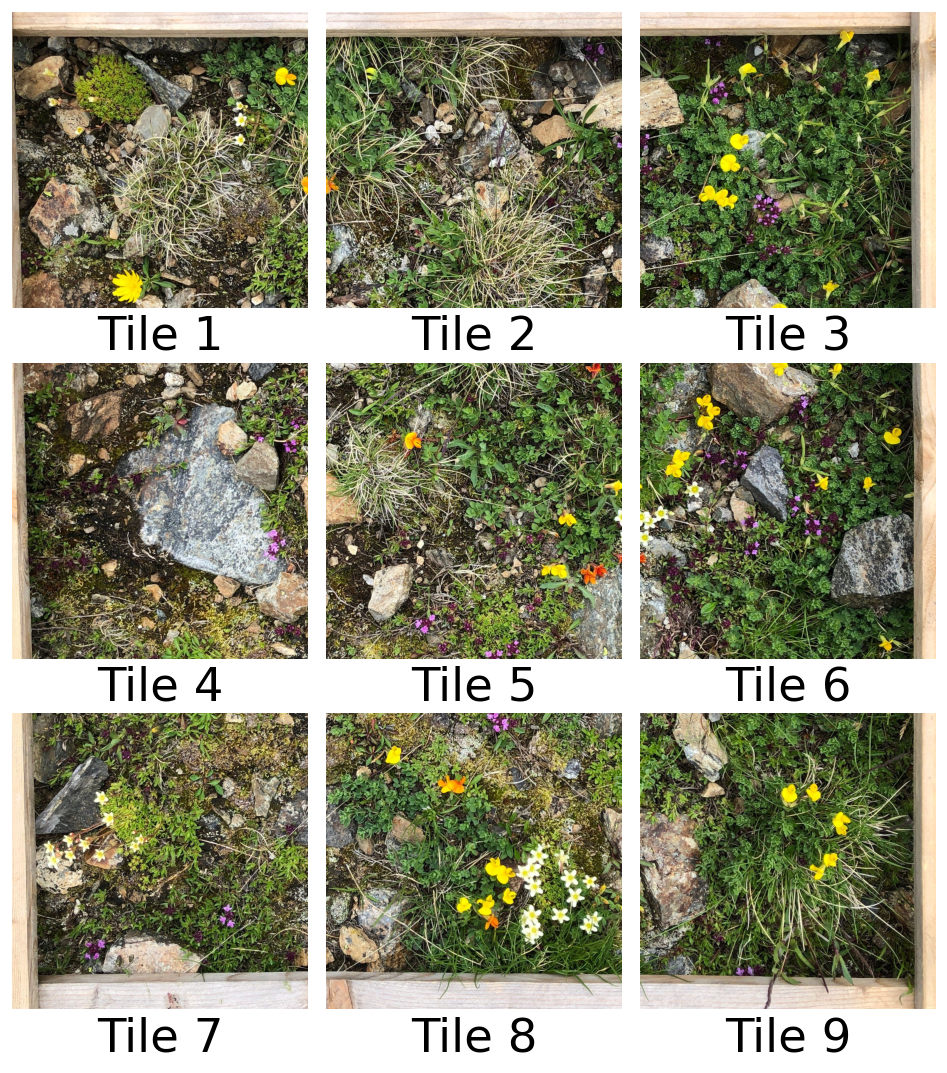

In [72]:
local_dir = Path(os.getcwd()).parents[1]
image_path = f"{local_dir}/figures/plantclef.jpg"

# plot image
plot_images_grid_from_path(image_path)

### grid embeddings

In [53]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
data_path = "data/process/test_v2/grid_dino_pretrained/data"

# paths to dataframe
grid_dino_path = f"{gcs_path}/{data_path}"
# read data
grid_dino_df = spark.read.parquet(grid_dino_path)
# show
grid_dino_df.show(n=5, truncate=50)

# order df for plotting
ordered_grid_dino_df = grid_dino_df.orderBy("image_name", "patch_number").limit(10)

+-------------------------------+------------+--------------------------------------------------+---------+
|                     image_name|patch_number|                                     cls_embedding|sample_id|
+-------------------------------+------------+--------------------------------------------------+---------+
|       CBN-PdlC-B6-20190909.jpg|           7|[0.567645, 1.6921916, -0.29813325, 0.15727657, ...|        6|
|       CBN-PdlC-F1-20200722.jpg|           5|[0.25926074, 2.0660655, -0.5255144, -0.58279055...|        6|
|OPTMix-0598-P4-108-20231207.jpg|           8|[-0.1416022, 0.50105137, -0.94805455, 1.6697326...|        6|
|        CBN-Pla-B6-20130904.jpg|           5|[-0.3612894, 1.0147426, -0.5758655, -1.1154238,...|        6|
|       CBN-PdlC-B5-20190722.jpg|           4|[0.57478356, 1.923769, -0.39382437, -0.6269862,...|        6|
+-------------------------------+------------+--------------------------------------------------+---------+
only showing top 5 rows



In [65]:
import math


def plot_images_from_embeddings(df, data_col: str, image_col: str, grid_size=(3, 3)):
    """
    Display images in a grid with species names as labels.

    :param df: DataFrame with the embeddings data.
    :param data_col: Name of the data column.
    :param image_col: Name of the species being displayed as image labels.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Collect binary image data from DataFrame
    subset_df = df.limit(rows * cols).collect()
    embedding_data_list = [row[data_col] for row in subset_df]
    image_names = [row[image_col] for row in subset_df]

    # Create a matplotlib subplot with specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(8, 10), dpi=300)

    # Flatten the axes array for easy iteration
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, embedding, name in zip(axes, embedding_data_list, image_names):
        # Find the next perfect square size greater than or equal to the embedding length
        next_square = math.ceil(math.sqrt(len(embedding))) ** 2
        padding_size = next_square - len(embedding)

        # Pad the embedding if necessary
        if padding_size > 0:
            embedding = np.pad(
                embedding, (0, padding_size), "constant", constant_values=0
            )

        # Reshape the embedding to a square
        side_length = int(math.sqrt(len(embedding)))
        image_array = np.reshape(embedding, (side_length, side_length))

        # Normalize the embedding to [0, 255] for displaying as an image
        normalized_image = (
            (image_array - np.min(image_array))
            / (np.max(image_array) - np.min(image_array))
            * 255
        )
        image = Image.fromarray(normalized_image).convert("L")

        ax.imshow(image, cmap="gray")
        ax.set_xlabel(f"Tile {name+1}")  # Set the species name as xlabel
        ax.xaxis.label.set_size(28)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    path = Path(os.getcwd()).parents[1]
    plt.savefig(f"{path}/figures/embedding-tiles.png", bbox_inches="tight")
    plt.show()

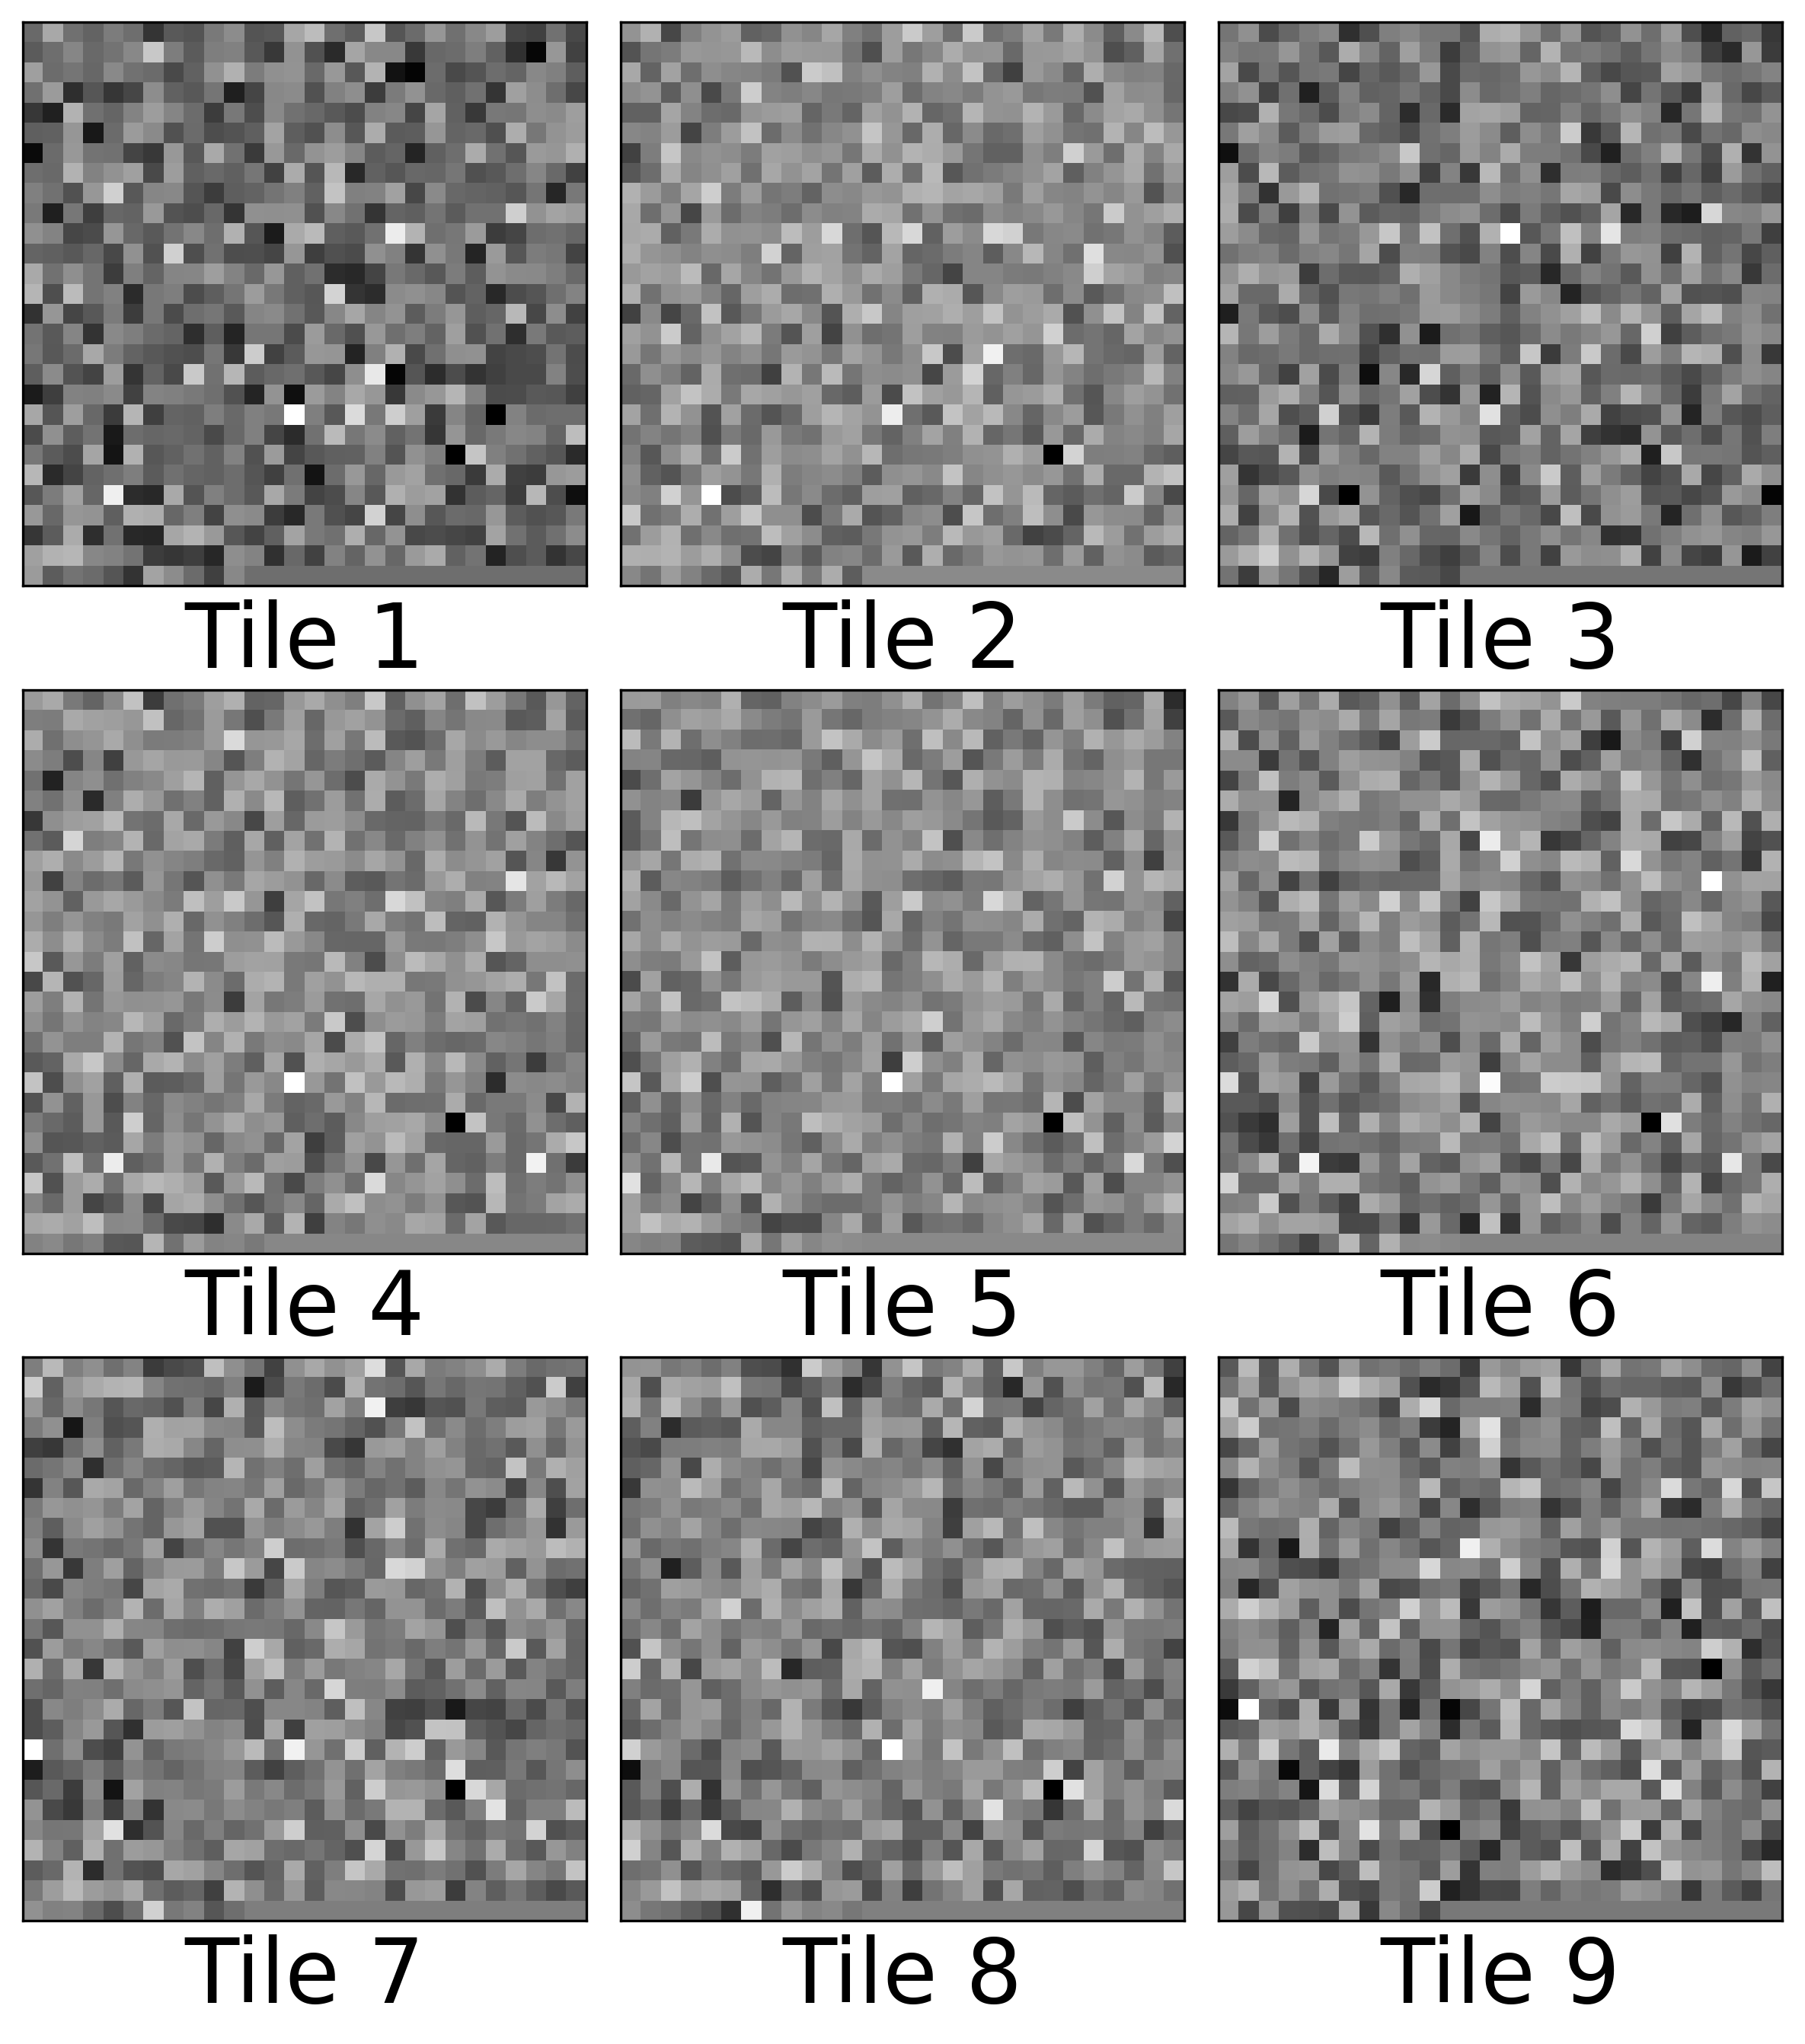

In [66]:
plot_images_from_embeddings(
    ordered_grid_dino_df, data_col="cls_embedding", image_col="patch_number"
)

### full-image plot

In [73]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
data_path = "data/process/test_v2/dino_pretrained/data"

# paths to dataframe
dino_path = f"{gcs_path}/{data_path}"
# read data
dino_df = spark.read.parquet(dino_path)
# show
dino_df.show(n=5, truncate=50)

+------------------------+--------------------------------------------------+---------+
|              image_name|                                     cls_embedding|sample_id|
+------------------------+--------------------------------------------------+---------+
| CBN-Pla-D6-20200723.jpg|[0.5568608, 1.5330836, 0.26619148, -0.22831053,...|        6|
|CBN-PdlC-D4-20130807.jpg|[1.3120965, 1.4474018, -1.1237478, 1.0732579, -...|        6|
|CBN-PdlC-A1-20150720.jpg|[0.1204187, 1.6437944, -2.1082246, 0.10812994, ...|        6|
| CBN-Pla-E3-20200814.jpg|[-0.020944202, 1.0298023, -0.25744364, -0.46665...|        6|
| CBN-Pla-D4-20200723.jpg|[0.6063784, 0.94524485, 0.23775575, -0.38850498...|        5|
+------------------------+--------------------------------------------------+---------+
only showing top 5 rows



In [88]:
def plot_emb_full_image(df, data_col):
    image_row = df.first()
    embedding = image_row[data_col]

    # Find the next perfect square size greater than or equal to the embedding length
    next_square = math.ceil(math.sqrt(len(embedding))) ** 2
    padding_size = next_square - len(embedding)

    # Pad the embedding if necessary
    if padding_size > 0:
        embedding = np.pad(embedding, (0, padding_size), "constant", constant_values=0)

    # Reshape the embedding to a square
    side_length = int(math.sqrt(len(embedding)))
    image_array = np.reshape(embedding, (side_length, side_length))

    # Normalize the embedding to [0, 255] for displaying as an image
    normalized_image = (
        (image_array - np.min(image_array))
        / (np.max(image_array) - np.min(image_array))
        * 255
    )
    image = Image.fromarray(normalized_image).convert("L")

    # Display the image using Matplotlib
    fig, ax = plt.subplots(dpi=300)
    ax.imshow(image, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    path = Path(os.getcwd()).parents[1]
    plt.savefig(f"{path}/figures/embedding-image.png", bbox_inches="tight")
    plt.show()

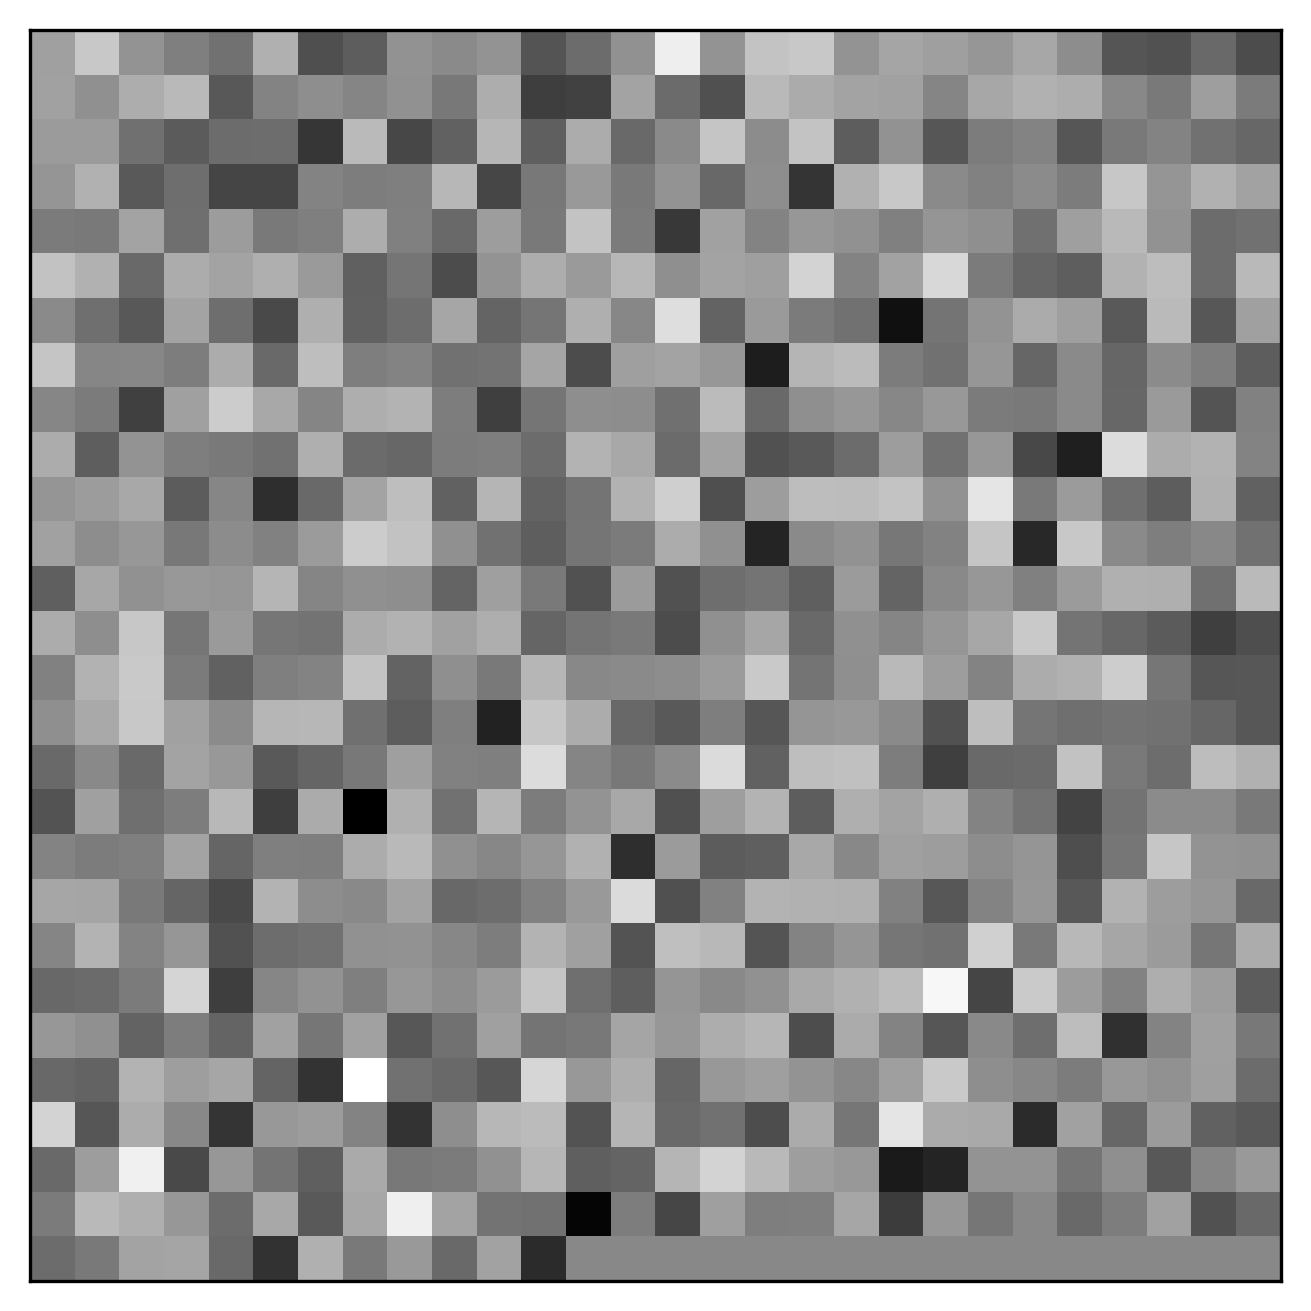

In [89]:
plot_emb_full_image(dino_df, data_col="cls_embedding")